In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session =tf.compat.v1.InteractiveSession(config=config)

import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.python.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.applications.densenet import preprocess_input as process_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as process_efficientnet
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.4.0


# **Loading the datasets**

In [2]:
general_path = '../input/cassava-leaf-disease-classification/'

train = pd.read_csv(general_path + 'train.csv')
train['label'] = train['label'].astype('str')
train.sample(5)

,image_id,label
20434,811928525.jpg,3
5447,1969558771.jpg,3
8306,2474746012.jpg,4
14559,3609064277.jpg,3
7902,2405316066.jpg,3


In [3]:
names_of_disease = pd.read_json(general_path + 'label_num_to_disease_map.json', typ='series')
names_of_disease

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

# Showing some pictures

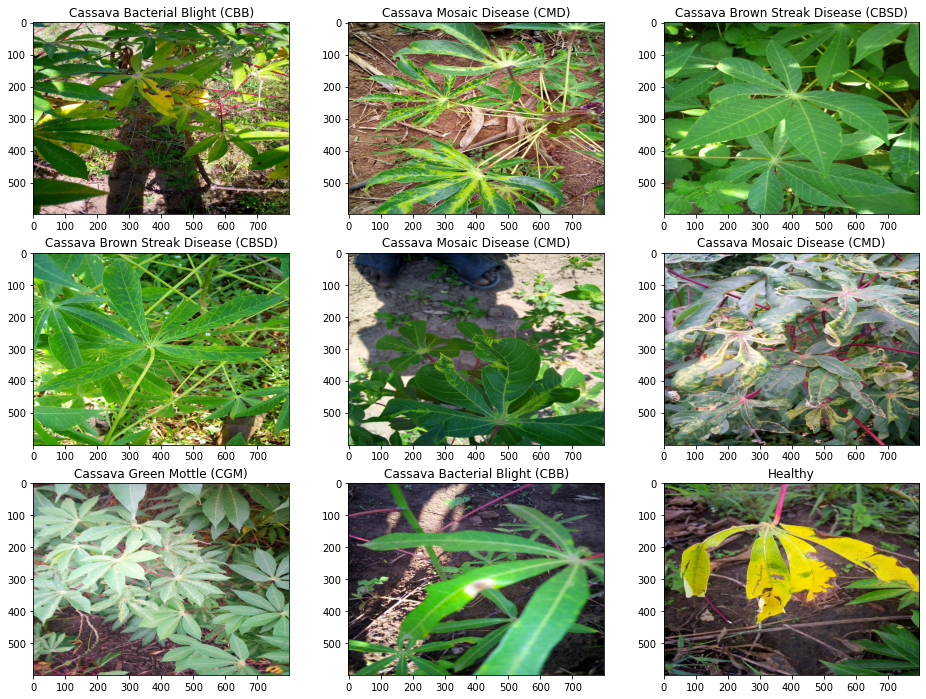

In [4]:
plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = Image.open(general_path + 'train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    plt.imshow(array)
    label=train.iloc[i]['label']
    plt.title(f'{names_of_disease[int(label)]}')
plt.show()

In [5]:
sizes = []
for i in range(1, len(train), 250):
    image = Image.open(general_path + 'train_images/' + train.iloc[i]['image_id'])
    array = np.array(image)
    sizes.append(array.shape)
print('Picture size', set(sizes))

Picture size {(600, 800, 3)}


In [6]:
img_width, img_height = 224, 224

# Data Augmentation

In [7]:
datagen = ImageDataGenerator(validation_split=0.1,
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             vertical_flip=True,
                             horizontal_flip=True)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    subset='training',
    seed=12345)


valid_datagen_flow = datagen.flow_from_dataframe(
    dataframe=train,
    directory=general_path + 'train_images',
    x_col='image_id',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode = 'categorical',
    subset='validation',
    seed=12345)

Found 19258 validated image filenames belonging to 5 classes.
Found 2139 validated image filenames belonging to 5 classes.


In [8]:
current_balance = train['label'].value_counts(normalize=True)
current_balance

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

# Models

In [9]:
SHAPE = (224,224,3)

inp = Input(SHAPE)
##############################################################
######################Model One###############################

 #one
conv_one_0 = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inp)
batch_one_0 = BatchNormalization(axis=3)(conv_one_0)

conv_one_1 = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(batch_one_0)
maxpool_one = MaxPooling2D(pool_size=(2, 2))(conv_one_1)
batch_one_1 = BatchNormalization(axis=3)(maxpool_one)
drop_one = Dropout(0.25)(batch_one_1)
    
#two
conv_two_0 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(drop_one)
batch_two_0 = BatchNormalization(axis=3)(conv_two_0)
    
conv_two_1 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(batch_two_0)
maxpool_two = MaxPooling2D(pool_size=(2, 2))(conv_two_1)
batch_two_1 = BatchNormalization(axis=3)(maxpool_two)
drop_two = Dropout(0.25)(batch_two_1)
    
#three
flat_three = Flatten()(drop_two)
# dense_three_0 = Dense(128, activation='relu')(flat_three)  # Fully connected layer
# batch_three_0 = BatchNormalization(axis=3)(dense_three_0)
# drop_three_0 = Dropout(0.5)(batch_three_0)
    
# dense_three_1 = Dense(60, activation="relu")(drop_three_0)  # Fully connected layer
# batch_three_1 = BatchNormalization(axis=3)(dense_three_1)
# out = Dropout(0.5)(batch_three_1)

one= Model(inputs=inp,outputs=flat_three)
#one.summary()  
   

In [10]:
##############################################################
######################Model Two############################### 
    
#one
conv_one_0_1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(inp)
batch_one_0_1= BatchNormalization(axis=3)(conv_one_0_1)
    
conv_one_1_1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(batch_one_0_1)
maxpool_one_1 = MaxPooling2D(pool_size=(2, 2))(conv_one_1_1)
batch_one_1_1 = BatchNormalization(axis=3)(maxpool_one_1)
#drop_one_1 = Dropout(0.25)(maxpool_one_1)
    
#two
conv_two_0_1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(batch_one_1_1)
batch_two_0_1 = BatchNormalization(axis=3)(conv_two_0_1)
    
conv_two_1_1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(batch_two_0_1)
maxpool_two_1 = MaxPooling2D(pool_size=(2, 2))(conv_two_1_1)
batch_two_1_1 = BatchNormalization(axis=3)(maxpool_two_1)
#drop_two_1 = Dropout(0.25)(maxpool_two_1)
    
#three
conv_three_0_1 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(batch_two_1_1)
batch_three_0_1 = BatchNormalization(axis=3)(conv_three_0_1)
    
conv_three_1_1 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(batch_three_0_1)
maxpool_three_1 = MaxPooling2D(pool_size=(2, 2))(conv_three_1_1)
batch_three_1_1 = BatchNormalization(axis=3)(maxpool_three_1)
#drop_three_1 = Dropout(0.5)(maxpool_three_1)
    
#four
flat_four_1 = Flatten()(batch_three_1_1)
# dense_four_0_1 = Dense(60, activation='relu')(flat_four_1)  # Fully connected layer
# #batch_four_0_1 = BatchNormalization()(dense_four_0_1)
# out_2 = Dropout(0.5)(dense_four_0_1)
    
#dense_four_1_1 = Dense(60, activation="relu")(drop_four_0_1)  # Fully connected layer
#batch_four_1_1 = BatchNormalization()(dense_four_1_1)
#out_2 = Dropout(0.5)(batch_four_1_1)

two= Model(inputs=inp,outputs=flat_four_1)
#two.summary()    

In [11]:
### Custom layer for weighted learnable ensemble ###

class weightedEnsemble(tf.keras.layers.Layer):
    def __init__(self,n_output):
        super(weightedEnsemble,self).__init__()
        self.W = tf.Variable(initial_value = tf.random.uniform(shape=[1,1,n_output],minval=0,maxval=1),trainable=True)
        
    def call(self,inputs):
        #inputs is list of tensor of shape[(n_batch,n_feat), ..., (n_batch,n_feat)]
        #expand last dim of each input passed [(n_batch, n_feat, 1), ...,(n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i,-1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) #(n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) #(1,1,n_inputs)
        # weights sum up to one on last dim
        return tf.reduce_sum(weights*inputs, axis=-1)

In [12]:
#weighted ensemble
# partial_output = [one.outputs[0],two.output]
# x = weightedEnsemble(n_output=len(partial_output))(partial_output)

merge = Concatenate()([one.outputs[0],two.outputs[0]])
#merge = Average()([one.outputs[0],two.outputs[0]])
hidden1 = Dense(512, activation='relu')(merge)
hidden2 = Dense(512, activation='relu')(hidden1)

output = Dense(5, activation='softmax')(hidden2)
model = Model(inputs=inp, outputs = output, name='ensemble')
opt = tf.keras.optimizers.Nadam(lr = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics='categorical_accuracy')
model.summary()


Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 222, 222, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 222, 222, 64) 256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 220, 220, 64) 36928       batch_normalization_4[0][0]      
___________________________________________________________________________________________

In [13]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
history = model.fit(train_datagen_flow,
                    validation_data=valid_datagen_flow, 
                    epochs=50,
                    #callbacks=[early_stop, reduce_lr], 
                    #use_multiprocessing=True,
                    #shuffle=True,
                    callbacks=[es],
                    verbose=2)

Epoch 1/50
301/301 - 600s - loss: 4.0920 - categorical_accuracy: 0.5196 - val_loss: 1.1354 - val_categorical_accuracy: 0.6288
Epoch 2/50
301/301 - 466s - loss: 1.0121 - categorical_accuracy: 0.6344 - val_loss: 1.3836 - val_categorical_accuracy: 0.6363
Epoch 3/50
301/301 - 443s - loss: 0.9103 - categorical_accuracy: 0.6621 - val_loss: 0.8670 - val_categorical_accuracy: 0.6695
Epoch 4/50
301/301 - 444s - loss: 0.8540 - categorical_accuracy: 0.6808 - val_loss: 0.9331 - val_categorical_accuracy: 0.6325
Epoch 5/50
301/301 - 436s - loss: 0.8113 - categorical_accuracy: 0.6942 - val_loss: 0.8976 - val_categorical_accuracy: 0.6676
Epoch 6/50
301/301 - 439s - loss: 0.7846 - categorical_accuracy: 0.7021 - val_loss: 1.5789 - val_categorical_accuracy: 0.4067
Epoch 7/50
301/301 - 505s - loss: 0.7574 - categorical_accuracy: 0.7171 - val_loss: 0.8902 - val_categorical_accuracy: 0.6709
Epoch 8/50
301/301 - 482s - loss: 0.7251 - categorical_accuracy: 0.7303 - val_loss: 0.9691 - val_categorical_accuracy:

In [14]:
model.save('cassava_model'+'.h5') 

# visualization of loss and accuracy

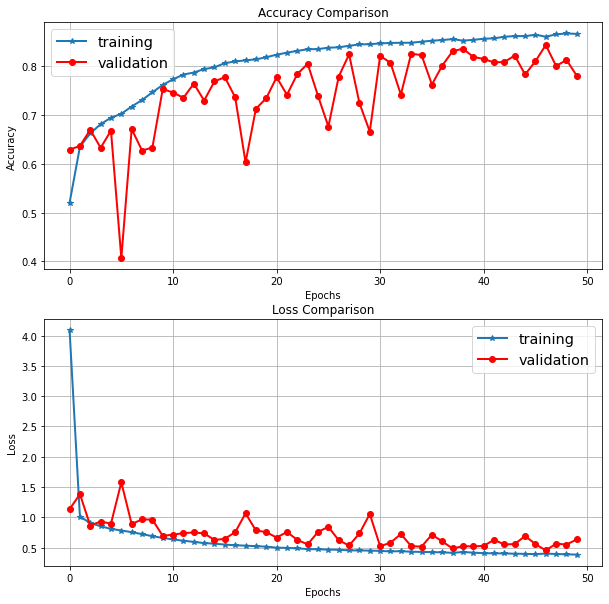

In [15]:
def visualize_training(history, lw = 2):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['categorical_accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_categorical_accuracy'], label = 'validation', marker = 'o', linewidth = lw, color='red')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')
    

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw, color='red')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()
    
visualize_training(history)

In [16]:
# Prediction accuracy on train data
score_tr = model.evaluate_generator(train_datagen_flow, verbose=1)
print("Prediction accuracy on train data =", score_tr[1])

# Prediction accuracy on test data
score_ts = model.evaluate_generator(valid_datagen_flow, verbose=1)
print("Prediction accuracy on test data =", score_ts[1])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


301/301 [==============================] - 440s 1s/step - loss: 0.5132 - categorical_accuracy: 0.8201
Prediction accuracy on train data = 0.8200747966766357
34/34 [==============================] - 52s 2s/step - loss: 0.6075 - categorical_accuracy: 0.7920
Prediction accuracy on test data = 0.7919588685035706


In [17]:
submission = pd.DataFrame(columns=['image_id','label'])
for image_name in os.listdir(general_path + 'test_images'):
    image_path = os.path.join(general_path + 'test_images', image_name)
    image = tf.keras.preprocessing.image.load_img(image_path)
    resized_image = image.resize((img_width, img_height))
    numpied_image = np.expand_dims(resized_image, 0)
    tensored_image = tf.cast(numpied_image, tf.float32)
    prediction = model.predict(tensored_image)
    prediction = np.argmax(prediction,axis=1)

    submission = submission.append(pd.DataFrame({'image_id': image_name,
                                                 'label': prediction}))
    
submission

,image_id,label
0,2216849948.jpg,2


In [18]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [19]:
# def model_one(inp):
    
#     #inp = Input(SHAPE)
    
#     #one
#     conv_one_0 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(inp)
#     batch_one_0 = BatchNormalization(axis=3)(conv_one_0)
    
#     conv_one_1 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(batch_one_0)
#     maxpool_one = MaxPooling2D(pool_size=(2, 2))(conv_one_1)
#     batch_one_1 = BatchNormalization(axis=3)(maxpool_one)
#     drop_one = Dropout(0.25)(batch_one_1)
    
#     #two
#     conv_two_0 = Conv2D(filters=128, kernel_size=(5, 5), activation='relu')(drop_one)
#     batch_two_0 = BatchNormalization(axis=3)(conv_two_0)
    
#     conv_two_1 = Conv2D(filters=128, kernel_size=(5, 5), activation='relu')(batch_two_0)
#     maxpool_two = MaxPooling2D(pool_size=(2, 2))(conv_two_1)
#     batch_two_1 = BatchNormalization(axis=3)(maxpool_two)
#     drop_two = Dropout(0.25)(batch_two_1)
    
#     #three
#     flat_three = Flatten()(drop_two)
#     dense_three_0 = Dense(512, activation='relu')(flat_three)  # Fully connected layer
#     batch_three_0 = BatchNormalization()(dense_three_0)
#     drop_three_0 = Dropout(0.5)(batch_three_0)
    
#     dense_three_1 = Dense(60, activation="relu")(drop_three_0)  # Fully connected layer
#     batch_three_1 = BatchNormalization()(dense_three_1)
#     out = Dropout(0.5)(batch_three_1)
    
#     #out = Dense(5, activation='softmax')(drop_three_1)
    
    
#     #return Model(inp,out)  
#     return out


# # ### UTILITY FUNCTION TO LOAD BASE MODELS ###

# def import_base_model(SHAPE):

#     #vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = SHAPE)
#     #vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = SHAPE)
#     resnet = tf.keras.applications.ResNet50( include_top= False, weights='imagenet', input_shape=SHAPE)
#     #densenet =tf.keras.applications.DenseNet121(include_top = False, weights = 'imagenet',input_shape = SHAPE)
#     efficientnet = tf.keras.applications.EfficientNetB4(include_top = False, weights = 'imagenet', input_shape=SHAPE)

# #     for layer in vgg16.layers[:-4]:
# #         layer.trainable = False

# #     for layer in vgg19.layers[:-5]:
# #         layer.trainable = False

# #     for layer in resnet.layers[:-10]:
# #         layer.trainable = False
        
#     for layer in resnet.layers:
#         layer.trainable = False
        
# #     for layer in densenet.layers:
# #         layer.trainable = False
    
#     for layer in efficientnet.layers:
#         layer.trainable =False
        
        
        
#     return resnet,efficientnet


### LOAD BASE MODELS ###
#SHAPE = (224,224,3)
# resnet, efficientnet = import_base_model(SHAPE)

#inp = Input(SHAPE)

# resnet_process = Lambda(process_resnet)(inp)
# res_net = resnet(resnet_process)
# x_resnet = GlobalMaxPool2D()(res_net)
# x_resnet = Dense(128, activation='relu')(x_resnet)

# # densenet_process = Lambda(process_densenet)(inp)
# # dense_net = densenet(densenet_process)
# # x_densenet = GlobarlMaxPool2D()(dense_net)
# # x_densenet = Dense(128, activation='relu')(x_densenet)

# efficientnet_process = Lambda(process_efficientnet)(inp)
# efficient_net = efficientnet(efficientnet_process)
# x_efficientnet = GlobalMaxPool2D()(efficient_net)
# x_efficientnet = Dense(128, activation='relu')(x_efficientnet)

# #x = Concatenate()([x_resnet, x_efficientnet])
# x = Average()([x_resnet, x_efficientnet])
# out = Dense(5, activation='softmax')(x)


# first_model = model_one(inp)
# second_model = model_two(inp)
# print(first_model)


# x = Concatenate()([first_model, second_model])
# #x = Average()([x_resnet, x_efficientnet])
# out = Dense(5, activation='softmax')(x)

# model = Model(inp, out)
# opt = tf.keras.optimizers.Adam(lr = 0.001)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics='categorical_accuracy')
# model.summary()

In [20]:
#valid_datagen_flow.class_indices